<a href="https://colab.research.google.com/github/l-makeup/bisindo-restnet/blob/main/bisindo_restnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
!pip install -q tensorflow kagglehub

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Download Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhshoburfattah/bisindo")

print("Path to dataset files:", path)

100%|██████████| 807M/807M [07:19<00:00, 1.93MB/s] 

Extracting files...


Path to dataset files: C:\Users\62823\.cache\kagglehub\datasets\muhshoburfattah\bisindo\versions\1


In [ ]:
# Path ke direktori dataset
train_dir = path + "\datatrain"

## Parameter Initialization

In [ ]:
# Parameter
img_height, img_width = 224, 224  # Ukuran input ResNet50
batch_size = 32
num_classes = 27  # A-Z + background


In [ ]:
# Preprocessing untuk ResNet50
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
)

# Training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1585 images belonging to 27 classes.
Found 376 images belonging to 27 classes.


In [ ]:
# Memuat model ResNet50 tanpa lapisan teratas
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Membekukan layers base_model agar tidak di-train ulang
for layer in base_model.layers:
    layer.trainable = False

# Menambahkan layers tambahan di atas base_model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Membuat model akhir
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

# Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size,
    epochs=15,
    verbose = 1
)

# Save Model
model.save('model.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

D:\PycharmProjects\DCML Preparation\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Plot Metric Performance

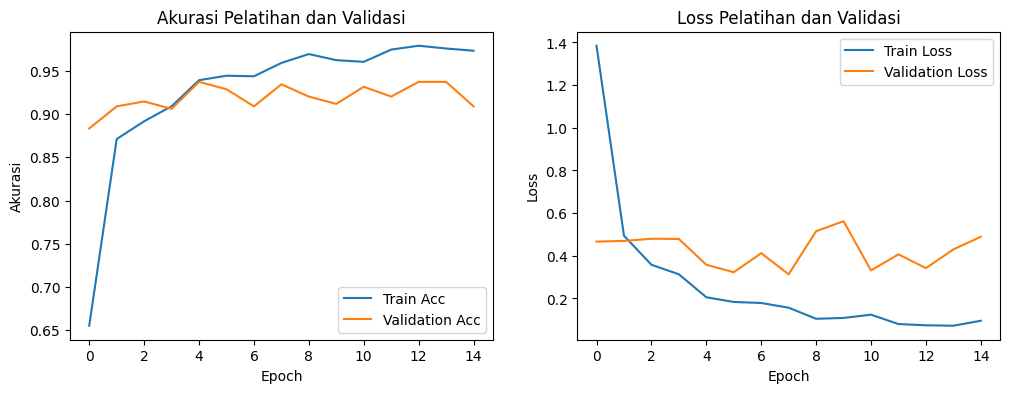

In [ ]:
# Plot akurasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.title('Akurasi Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Model Pruning

In [ ]:
import numpy as np
import tensorflow_model_optimization as tfmot

# Definisikan parameter pruning
batch_size = 32
epochs = 5
validation_split = 0.2

num_images = train_generator.n
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=0.80,
        begin_step=0,
        end_step=end_step
    )
}

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

model_pruned = tf.keras.models.clone_model(
    model,
    clone_function=lambda layer: prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)) else layer
)

model_pruned.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 prune_low_magnitude_conv1_  (None, 112, 112, 64)         18882     ['conv1_pad[4][0]']           
 conv (PruneLowMagnitude)                                                                         
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['prune_low_magnitude_conv

In [ ]:
# Compile ulang model
model_pruned.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir='pruning_logs')
]

history = model_pruned.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# Menghapus wrappers pruning
model_pruned = tfmot.sparsity.keras.strip_pruning(model_pruned)

# Menyusun ulang model akhir
model_pruned.save('model_pruned.h5')

Epoch 1/5
49/49 [==============================] - 90s 2s/step - loss: 1.4376 - accuracy: 0.5776 - val_loss: 1.2255 - val_accuracy: 0.6818
Epoch 2/5
49/49 [==============================] - 80s 2s/step - loss: 1.0509 - accuracy: 0.7115 - val_loss: 1.1074 - val_accuracy: 0.7330
Epoch 3/5
49/49 [==============================] - 78s 2s/step - loss: 0.7500 - accuracy: 0.7875 - val_loss: 0.7619 - val_accuracy: 0.8011
Epoch 4/5
49/49 [==============================] - 81s 2s/step - loss: 0.6177 - accuracy: 0.8249 - val_loss: 0.7426 - val_accuracy: 0.8011
Epoch 5/5
49/49 [==============================] - 79s 2s/step - loss: 0.7286 - accuracy: 0.8062 - val_loss: 0.7341 - val_accuracy: 0.8608


## Compare Baseline Model and Pruned Model

### Compare Accuracy Model

In [ ]:
# Load model
model_baseline = tf.keras.models.load_model('model.h5')
model_pruned = tf.keras.models.load_model('model_pruned.h5')

# Compile ulang model
model_pruned.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Evaluate model
_, model_baseline_accuracy = model_baseline.evaluate(
   validation_generator, verbose=1)

_, model_pruned_accuracy = model_pruned.evaluate(
   validation_generator, verbose=1)

print('Baseline test accuracy:', model_baseline_accuracy)
print('Pruned test accuracy:', model_pruned_accuracy)

12/12 [==============================] - 16s 1s/step - loss: 0.7780 - accuracy: 0.8431
Baseline test accuracy: 0.914893627166748
Pruned test accuracy: 0.8430851101875305


### Compare Size Model

In [ ]:
# Helper function untuk mengompresi model melalui gzip dan mendapatkan ukuran zip.
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

baseline_size = (get_gzipped_model_size('model.h5'))
pruned_size = (get_gzipped_model_size('model_pruned.h5'))

# Konversi ukuran file ke kilobyte (KB) atau megabyte (MB)
baseline_size_kb = baseline_size / 1024
pruned_size_kb = pruned_size / 1024
baseline_size_mb = baseline_size_kb / 1024
pruned_size_mb = pruned_size_kb / 1024

# Menampilkan hasil
print(f"Baseline Model Size: {baseline_size_kb:.2f} KB ({baseline_size_mb:.2f} MB)")
print(f"Pruned Model Size: {pruned_size_kb:.2f} KB ({pruned_size_mb:.2f} MB)")

# Membandingkan ukuran file
reduction = ((baseline_size - pruned_size) / baseline_size) * 100
print(f"Reduction in size: {reduction:.2f}%")

Baseline Model Size: 97172.62 KB (94.90 MB)
Pruned Model Size: 28615.22 KB (27.94 MB)
Reduction in size: 70.55%
